In [1]:
import os
import glob
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
conf_list = ["AAAI", "CVPR", "ICML", "KDD", "NeurIPS1"]
conf_map = {name: i for i, name in enumerate(conf_list)}
root_dir = "spider"
batch_size = 8
num_epochs = 100

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备:", device)

使用设备: cuda


In [4]:
entity_df = pd.read_csv("entity_embeddings.csv", index_col=0)
entity_emb_dict = entity_df.to_dict(orient="index")
kg_dim = len(next(iter(entity_emb_dict.values())))

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()  # 推理阶段禁用 dropout

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
class PaperDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.text_features = []
        self.labels = []

        for conf in conf_list:
            txt_dir = os.path.join(root_dir, conf, "txt")
            for path in glob.glob(os.path.join(txt_dir, "*.txt")):
                with open(path, "r", encoding="utf-8", errors="ignore") as f:
                    text = f.read()
                paper_id = os.path.basename(path).replace(".txt", "")
                label = conf_map[conf]

                # 提取 BERT 文本嵌入（提前缓存）
                tokens = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256).to(device)
                with torch.no_grad():
                    text_emb = bert_model(**tokens).pooler_output.squeeze(0).cpu()  # 保存在 CPU，稍后统一转 device

                self.samples.append(paper_id)
                self.text_features.append(text_emb)
                self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        paper_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        text_emb = self.text_features[idx].to(device)  # 显式转移到 device

        # 获取图谱向量（无则填零）
        if paper_id in entity_emb_dict:
            kg_vector = list(entity_emb_dict[paper_id].values())
            kg_emb = torch.tensor(kg_vector, dtype=torch.float)
        else:
            kg_emb = torch.zeros(kg_dim, dtype=torch.float)

        kg_emb = kg_emb.to(device)
        return torch.cat([text_emb, kg_emb]), label.to(device)

In [7]:
class PaperClassifier(nn.Module):
    def __init__(self, kg_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(768 + kg_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [8]:
dataset = PaperDataset(root_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = PaperClassifier(kg_dim=kg_dim, num_classes=len(conf_list)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
loss_list = []
acc_list = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (logits.argmax(1) == y).sum().item()

    acc = correct / len(dataset)
    loss_list.append(total_loss)
    acc_list.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f} | Acc: {acc:.4f}")


Epoch 1/100 | Loss: 94.5211 | Acc: 0.4141
Epoch 2/100 | Loss: 83.1919 | Acc: 0.4747
Epoch 3/100 | Loss: 78.7425 | Acc: 0.5354
Epoch 4/100 | Loss: 76.5659 | Acc: 0.5438
Epoch 5/100 | Loss: 73.7214 | Acc: 0.5455
Epoch 6/100 | Loss: 71.4477 | Acc: 0.5943
Epoch 7/100 | Loss: 69.6816 | Acc: 0.5791
Epoch 8/100 | Loss: 67.2470 | Acc: 0.5909
Epoch 9/100 | Loss: 67.0860 | Acc: 0.6010
Epoch 10/100 | Loss: 64.9247 | Acc: 0.6296
Epoch 11/100 | Loss: 63.8748 | Acc: 0.6296
Epoch 12/100 | Loss: 62.8286 | Acc: 0.6279
Epoch 13/100 | Loss: 62.0044 | Acc: 0.6532
Epoch 14/100 | Loss: 59.9686 | Acc: 0.6330
Epoch 15/100 | Loss: 58.6732 | Acc: 0.6785
Epoch 16/100 | Loss: 58.0929 | Acc: 0.6801
Epoch 17/100 | Loss: 57.4250 | Acc: 0.6667
Epoch 18/100 | Loss: 56.3474 | Acc: 0.6818
Epoch 19/100 | Loss: 54.6607 | Acc: 0.6970
Epoch 20/100 | Loss: 54.2200 | Acc: 0.7121
Epoch 21/100 | Loss: 53.7501 | Acc: 0.6987
Epoch 22/100 | Loss: 53.0835 | Acc: 0.6852
Epoch 23/100 | Loss: 52.3789 | Acc: 0.7037
Epoch 24/100 | Loss:

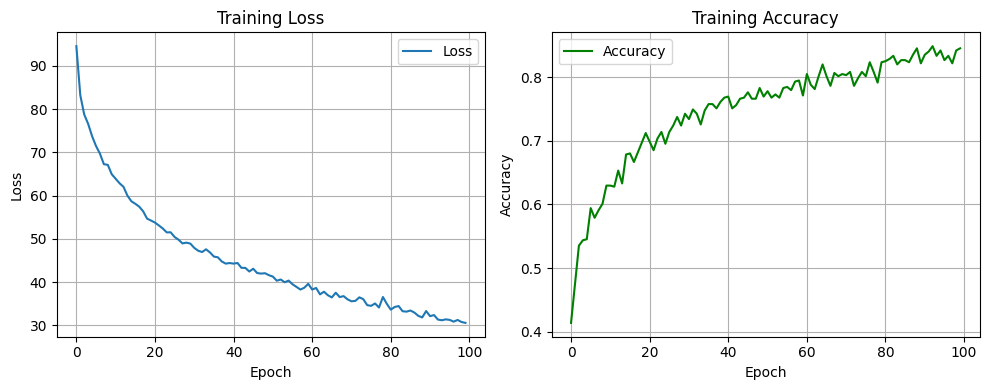

In [10]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_list, label="Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
all_probs = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

preds = torch.tensor(all_probs).argmax(dim=1).numpy()
accuracy = accuracy_score(all_labels, preds)
precision = precision_score(all_labels, preds, average='macro')
recall = recall_score(all_labels, preds, average='macro')
f1 = f1_score(all_labels, preds, average='macro')

print("\n=== Final Evaluation Metrics ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


=== Final Evaluation Metrics ===
Accuracy:  0.8468
Precision: 0.8840
Recall:    0.8269
F1 Score:  0.8506


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_31032\3097250365.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  preds = torch.tensor(all_probs).argmax(dim=1).numpy()
